In [0]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
import numpy as np
import os
from imageio import imread
from PIL import Image

import pandas as pd

#np.array(Image.fromarray(img).resize([dimx,dimy]))

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    
data, attrs = fetch_dataset()
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
print(IMAGE_H, IMAGE_W)

45 45


In [0]:
from sklearn.model_selection import train_test_split
data = np.array(data / 255, dtype='float32')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

In [0]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

In [0]:
inp_size=X_train.shape[1]
hid_size=250
dim_z=100 

In [9]:
X_train.shape

torch.Size([10514, 45, 45, 3])

In [0]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.ReLU(),
            #nn.Linear(1000,500),
            #nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.ReLU(),
            #nn.Linear(500,1000),
            #nn.ReLU(),
            nn.Linear(1000,1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )
        
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        #print("shape",x.shape)
        
        #x = x.view(-1,45*45*3)
        encoded = self.encoder(x)
        #latent_view = self.latent_view(encoder)
        #decoder = self.decoder(latent_view).resize_((45,45,3))   
        decoded = self.decode(encoded)     

        
        return encoded, decoded
        return reconstruction, latent_code


In [11]:
model_auto = Autoencoder().to(device)
print(model_auto)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6075, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=100, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=1500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1500, out_features=6075, bias=True)
  )
)


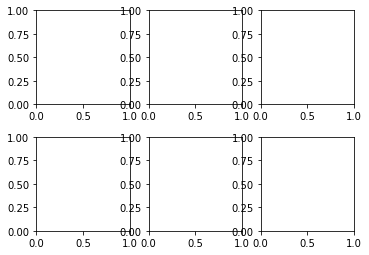

In [12]:
plot_gallery([X_val], IMAGE_H, IMAGE_W, n_row=2, n_col=3)

In [0]:
def get_batch(data, batch_size=32):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        #print('decoder shape: ', decoder.shape)
        
        if not is_cnn:
            outputs = decoder.view(-1, 45*45*3)
        else:
            outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            if not is_cnn:
                outputs = decoder.view(-1, 45*45*3)
            else:
                outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        if not is_cnn:            
            pic_input = pic.view(-1, 45*45*3)
        else:
            #print(pic.shape)
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
            #print(pic.shape)
            
        pic_input = pic_input.to(DEVICE)
        
        encoder, decoder = model(pic_input)
        
        if not is_cnn:
            pic_output = decoder.view(-1, 45*45*3).squeeze()
        else:
            #print('decoder shape eval: ', decoder.shape)
            pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")
        #pic_output = pic_output.view(-1, 45,45,3)
        
        #print(pic)
        #print(pic_output)
        
        pic_input = pic_input.to("cpu")
        #pics = pic_input + pic_output
        
        #plot_gallery(pics,45,45,10,2)
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=False):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
            
    return history

In [0]:
history = train(X_train, X_val, model_auto, epochs=50, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

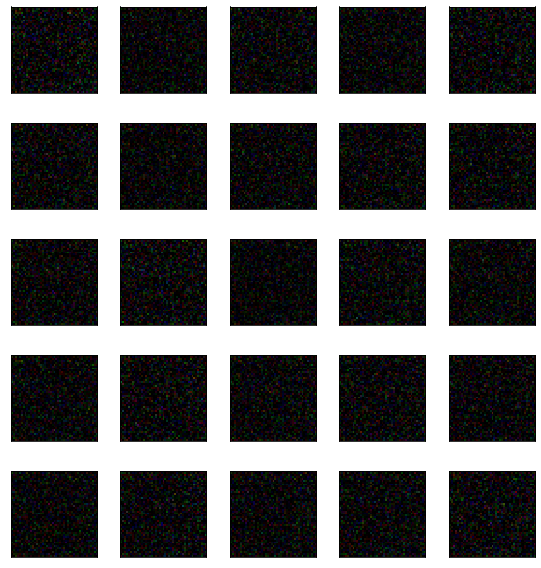

In [15]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)
    
    inputs = inputs.to(device)
    model_auto.eval()
    output = model_auto.decode(inputs)
    
    #print(output)
    
    plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=5, n_col=5)

In [0]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]

no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

eyeglasses_ids = attrs['Eyeglasses'].sort_values(ascending=False).head(25).index.values
eyeglasses_data = data[eyeglasses_ids]

sunglasses_ids = attrs['Sunglasses'].sort_values(ascending=False).head(25).index.values
sunglasses_data = data[sunglasses_ids]

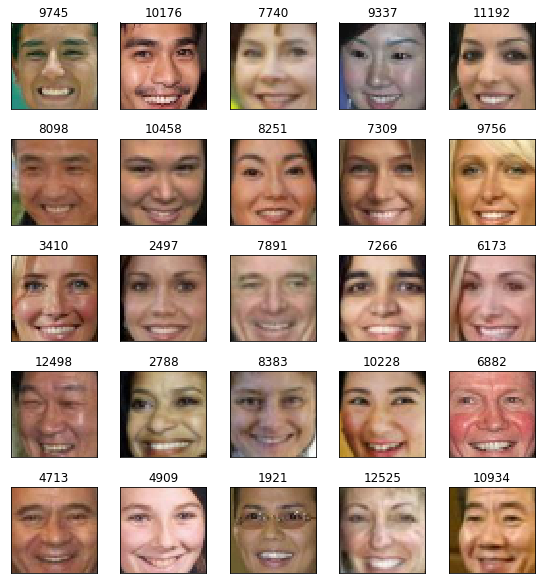

In [0]:
plot_gallery(smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=smile_ids)

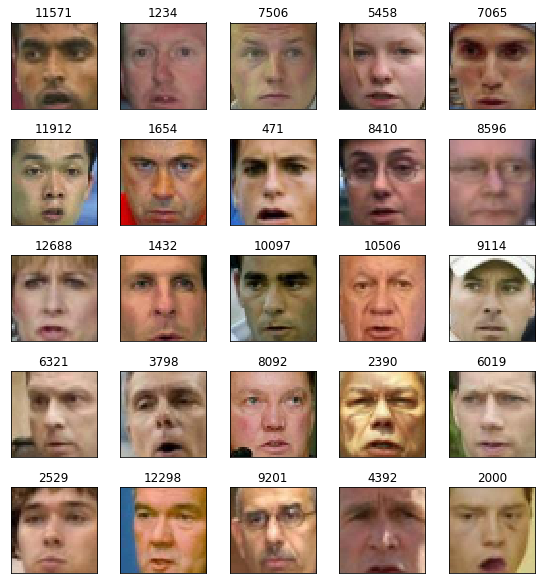

In [17]:
plot_gallery(no_smile_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=no_smile_ids)

In [0]:
plot_gallery(eyeglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=eyeglasses_ids)

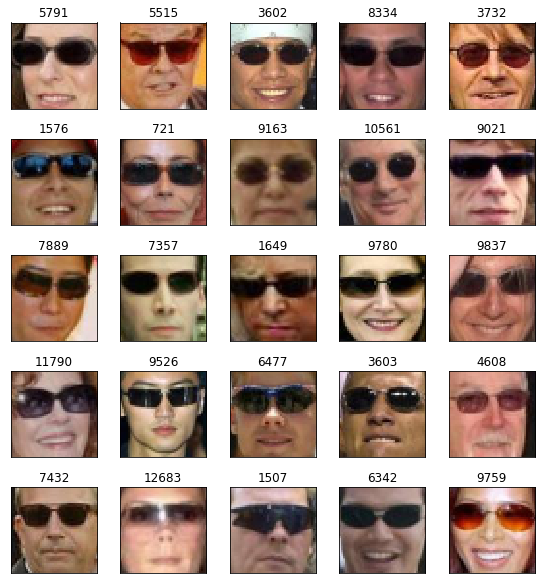

In [18]:
plot_gallery(sunglasses_data, IMAGE_H, IMAGE_W, n_row=5, n_col=5, with_title=True, titles=sunglasses_ids)

In [0]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(device)
        model_auto.eval()
        output = model_auto.encoder(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(device)
        model_auto.eval()
        output = model_auto.decoder(inputs)        
        return output

In [20]:
smile_data[0].reshape(-1,45*45*3).shape

(1, 6075)

In [0]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)
sunglasses_latent = to_latent(sunglasses_data).mean(axis=0)

smile_vec = smile_latent-no_smile_latent
sunglasses_vec = sunglasses_latent - smile_latent

def make_me_smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
        
def give_me_sunglasses(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += sunglasses_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

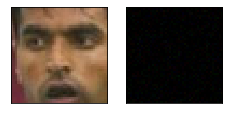

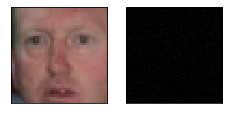

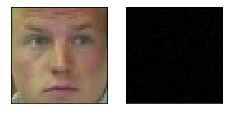

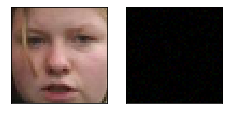

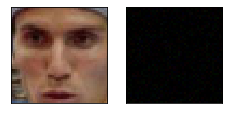

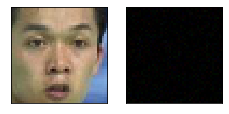

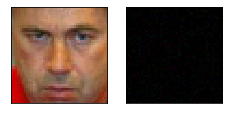

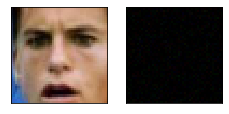

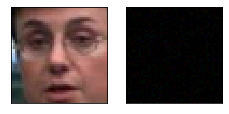

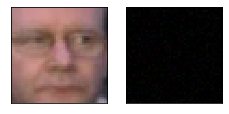

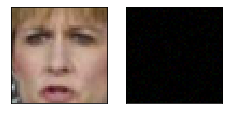

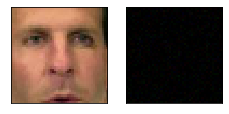

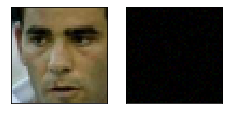

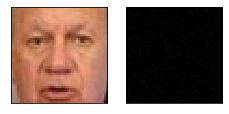

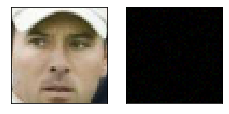

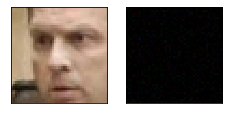

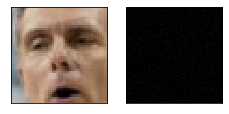

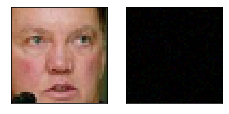

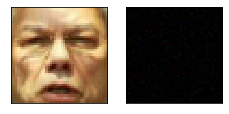

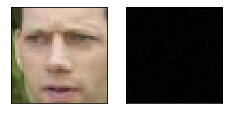

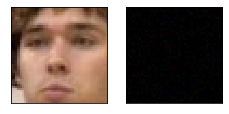

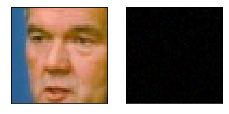

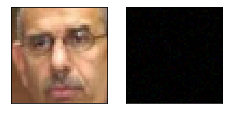

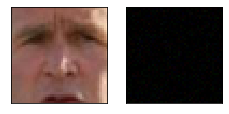

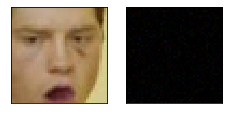

In [22]:
make_me_smile(no_smile_ids)